In [1]:
import numpy as np
import pandas as pd
import utilities as utils
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

In [2]:
rawdata = pd.read_csv("world-food-facts/FoodFacts.csv")

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
not_null_data = rawdata[rawdata.nutrition_score_uk_100g.notnull()]

In [4]:
nutriment_cols = [col for col in not_null_data.columns if '_100g' in col and not 'score' in col]
data = not_null_data[nutriment_cols]
data = data.fillna(0) #fill nulls with 0 for now
data.shape

(31294, 94)

In [5]:
target = not_null_data.nutrition_score_uk_100g.loc[data.index.values]
target.shape

(31294,)

### Linear regression to predict nutrition score

In [6]:
x = data.as_matrix()
y = target.as_matrix()

In [7]:
x = np.array([np.concatenate((v,[1])) for v in x]) #add column of ones to the end of the data set
print x

[[ 1284.      0.      7.      3.6 ...,     0.      0.      0.      1. ]
 [ 1284.      0.      7.      3.6 ...,     0.      0.      0.      1. ]
 [  177.      0.      0.      0.  ...,     0.      0.      0.      1. ]
 [  177.      0.      0.      0.  ...,     0.      0.      0.      1. ]
 ..., 
 [ 2111.      0.     53.3     3.8 ...,     0.      0.      0.      1. ]
 [  660.      0.      6.9     0.5 ...,     0.      0.      0.      1. ]
 [ 1643.      0.      2.8     0.6 ...,     0.      0.      0.      1. ]
 [   21.      0.      0.2     0.2 ...,     0.      0.      0.      1. ]]


In [8]:
linreg = LinearRegression()
linreg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
p = linreg.predict(x)
p

array([ 10.81,  10.81,   0.62,   0.66, ...,  15.35,   4.36,   3.81,  -1.75])

In [10]:
err = abs(p-y)
err

array([ 0.81,  0.81,  1.38,  1.34, ...,  1.65,  1.64,  7.81,  1.75])

In [11]:
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))
rmse_train

4.6161598836408091

In [12]:
linreg.coef_ #Regression Coefficients

array([      0.  ,       0.  ,       0.09,       0.32,       0.  ,       0.  ,       0.  ,       0.  ,      -0.77,
            -0.  ,      -0.  ,      -0.  ,      -7.28,       0.  ,       0.  ,      -0.  ,      -0.  ,      -0.  ,
            -0.08,      -0.05,      -0.1 ,      -0.02,       7.75,      -4.79,      -0.04,       0.15,     116.67,
         -6932.67,       0.  ,      -0.04,      -0.06,      -0.  ,      -0.  ,       0.  ,       0.  ,       0.  ,
             0.  ,      -1.5 ,      -0.04,       0.21,       0.15,       0.  ,      -0.07,      -0.05,       0.02,
             0.02,       0.01,       0.04,      -0.57,       0.16,       0.19,      -0.09,    -353.97,     117.67,
          -297.78,       0.07,      31.08,      17.76,       0.41,      -0.1 ,     -27.46,      -0.73,     -82.62,
           384.48,       0.02,     -27.13,      12.51,  251068.35,  -22217.04,       2.13,    -156.01,      48.78,
            -0.09,      14.35,       0.09,      -7.3 ,      -0.04,       8.08,  

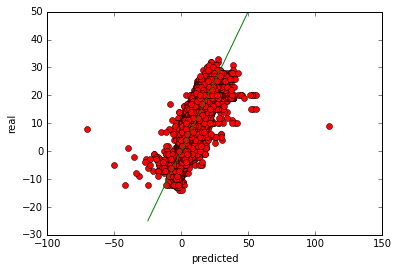

In [13]:
pl.plot(p, y,'ro')
pl.plot([-25,50],[-25,50], 'g-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [14]:
# RMSE with 10-Fold Cross Validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    linreg.fit(x[train],y[train])
    p = linreg.predict(x[test])
    e = p-y[test]
    print e
    xval_err += np.dot(e,e)
    
rmse_10cv = np.sqrt(xval_err/len(x))

[ 0.76  0.76 -1.49 -1.45 ...,  0.56  1.55  1.15 -2.44]
[-5.15 -0.91  3.81 -3.4  ...,  2.76  6.42  1.19  3.42]
[ 6.42  1.32 -2.04  0.8  ...,  0.63  1.38  3.75 -0.09]
[-4.35 -0.46 -5.41 -0.17 ..., -2.61 -4.43 -2.8  -4.74]
[-4.83 -3.33 -3.31 -2.51 ...,  2.93  0.76  1.35 -6.99]
[-6.95 -6.83 -6.51 -6.02 ...,  2.87  5.29 -0.39 -1.72]
[-5.22  1.28  7.81  7.81 ..., -6.91  3.66  0.8  -6.67]
[-8.32 -1.17  3.39 -4.16 ...,  0.29  3.6   3.01  3.27]
[ 8.76  7.63 -2.28 -8.04 ..., -2.8  -8.21 -0.44 -0.44]
[-2.68 -3.84 -1.35 -0.84 ..., -1.21 -1.63  6.97 -1.87]


In [15]:
print('Method: Linear Regression')
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Linear Regression
RMSE on training: 4.6162
RMSE on 10-fold CV: 1418.3081


whoa! linear regression rmse on 10-fold cross validation is terrible!! let's try something else

### Ridge, Lasso, Elastic-Net Regression

In [16]:
print('alpha\t\tridge\t\tlasso\t\telastic-net\n')
alpha = np.linspace(0.01,0.5,50)
for a in alpha:
    results = []
    for name,met in [
            #('linear regression', LinearRegression()),
            ('ridge', Ridge(fit_intercept=True, alpha=a)),
            ('lasso', Lasso(fit_intercept=True, alpha=a)),
            ('elastic-net', ElasticNet(fit_intercept=True, alpha=a))
            ]:
        #met.fit(x,y)
        #p = met.predict(x)
        #e = p-y
        #total_error = np.dot(e,e)
        #rmse_train = np.sqrt(total_error/len(p))

        kf = KFold(len(x), n_folds=10)
        err = 0
        for train,test in kf:
            met.fit(x[train],y[train])
            p = met.predict(x[test])
            e = p-y[test]
            err += np.dot(e,e)

        rmse_10cv = np.sqrt(err/len(x))
        
        results.append(rmse_10cv)
        
    print('{:.3f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\n'.format(a,results[0],results[1],results[2]))

alpha		ridge		lasso		elastic-net

0.010		28.8886		4.7091		4.7099

0.020		16.2765		4.7095		4.7091

0.030		11.7676		4.7096		4.7093

0.040		9.5467		4.7094		4.7094

0.050		8.2726		4.7091		4.7094

0.060		7.4714		4.7088		4.7094

0.070		6.9348		4.7085		4.7094

0.080		6.5579		4.7083		4.7093

0.090		6.2832		4.7081		4.7091

0.100		6.0768		4.7079		4.7090

0.110		5.9175		4.7078		4.7088

0.120		5.7919		4.7077		4.7086

0.130		5.6910		4.7076		4.7085

0.140		5.6084		4.7075		4.7084

0.150		5.5399		4.7074		4.7082

0.160		5.4823		4.7073		4.7081

0.170		5.4333		4.7072		4.7081

0.180		5.3911		4.7071		4.7080

0.190		5.3544		4.7071		4.7079

0.200		5.3222		4.7070		4.7078

0.210		5.2937		4.7070		4.7078

0.220		5.2684		4.7069		4.7077

0.230		5.2456		4.7069		4.7077

0.240		5.2251		4.7069		4.7076

0.250		5.2065		4.7069		4.7076

0.260		5.1895		4.7069		4.7075

0.270		5.1738		4.7070		4.7075

0.280		5.1595		4.7070		4.7075

0.290		5.1461		4.7071		4.7074

0.300		5.1338		4.7072		4.7074

0.310		5.1223		4.7073		4.7074

0.

### The best regression method was Lasso with an alpha value of 0.23

Lasso Regression w/ alpha=0.23


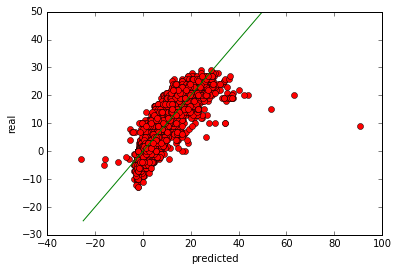

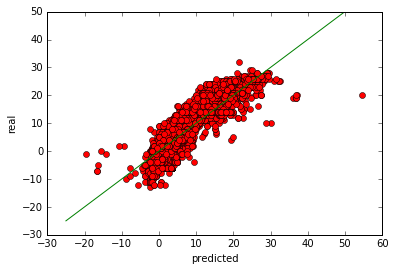

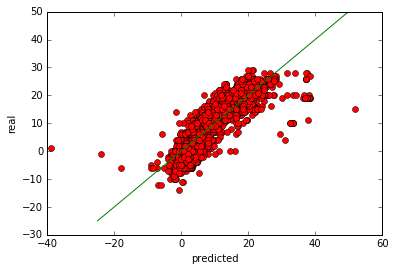

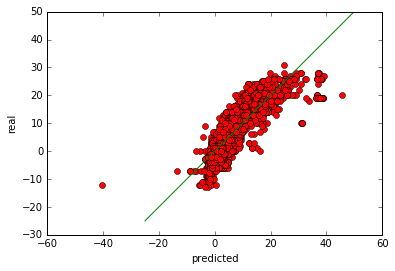

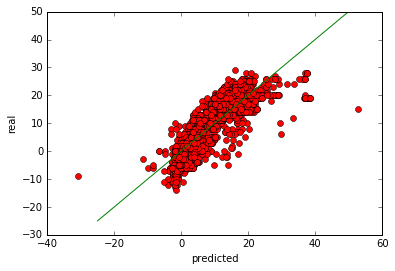

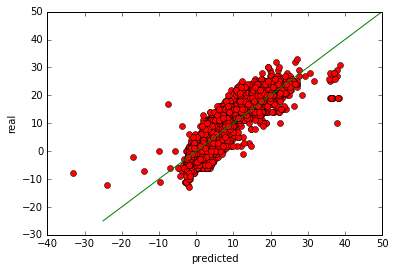

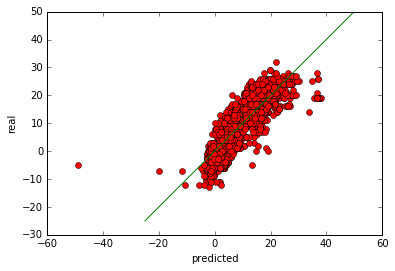

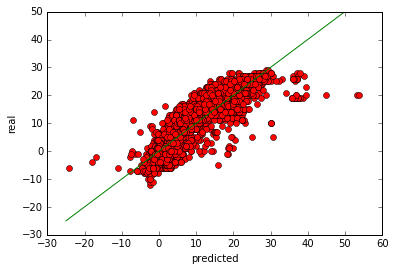

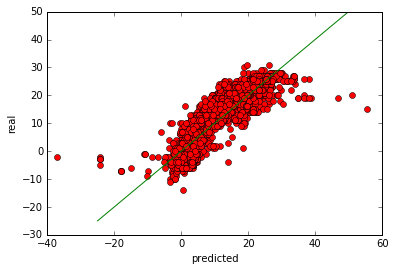

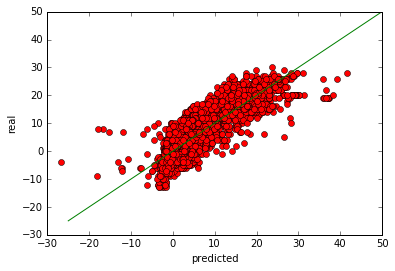

rsme with 10-fold cross validation = 4.7069


In [17]:
print('Lasso Regression w/ alpha=0.23')
ridge = Lasso(fit_intercept=True, alpha=0.23)

# computing RMSE using 10-fold cross validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train, test in kf:
    ridge.fit(x[train], y[train])
    p = ridge.predict(x[test])
    err = p - y[test]
    xval_err += np.dot(err,err)
    
    pl.plot(p, y[test],'ro')
    pl.plot([-25,50],[-25,50], 'g-')
    pl.xlabel('predicted')
    pl.ylabel('real')
    pl.show()
    
rmse_10cv = np.sqrt(xval_err/len(x))

print('rsme with 10-fold cross validation = {:.4f}'.format(rmse_10cv))

That's alot better!